PART 3: DATA PREPARATION AND MODEL TRAINING

STEP 1: LOADING DATASET

Dataset loaded successfully!
Total records: 4644
Total columns: 11

First 5 rows:
   work_year experience_level employment_type  \
0       2020               EX              FT   
1       2020               MI              FT   
2       2020               MI              FT   
3       2020               MI              FT   
4       2020               SE              FT   

                                  job_title  salary salary_currency  \
0                            Data Scientist  300000             USD   
1  Machine Learning Infrastructure Engineer   44000             EUR   
2                         Lead Data Analyst   87000             USD   
3                             Data Engineer   88000             GBP   
4                       Lead Data Scientist  190000             USD   

   salary_in_usd employee_residence  remote_ratio company_location  \
0         300000                 US           100       

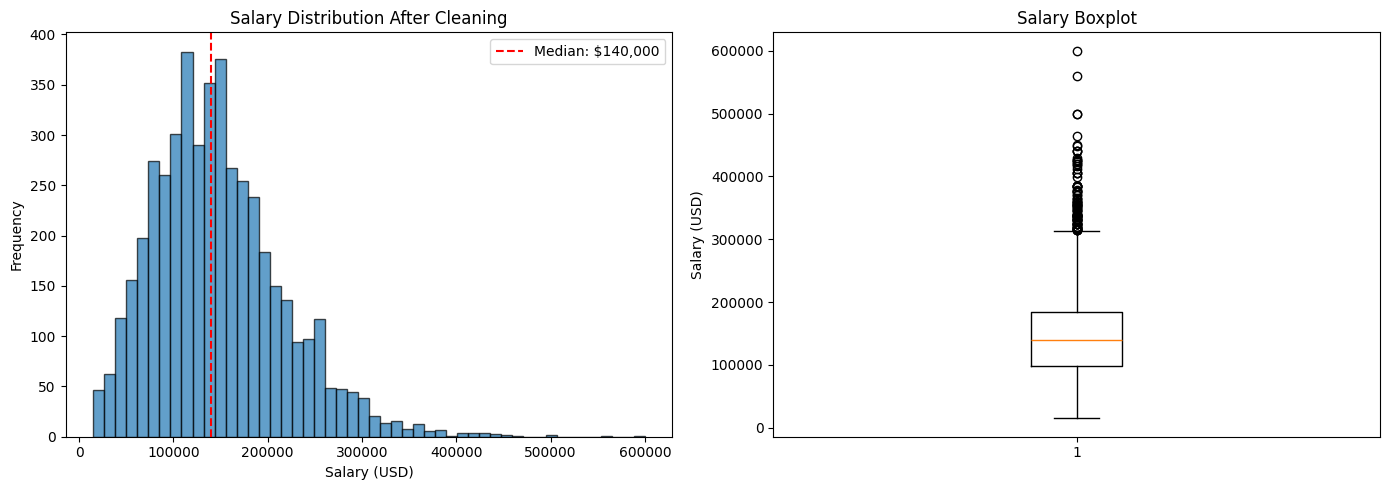


✅ Salary distribution plot saved as 'salary_distribution.png'

STEP 4: FEATURE SELECTION

Categorical Feature Analysis:

1. experience_level: ['EX' 'MI' 'SE' 'EN']
   Distribution:
experience_level
SE    2736
MI    1374
EN     400
EX     129
Name: count, dtype: int64

2. employment_type: ['FT' 'PT' 'CT' 'FL']
   Distribution:
employment_type
FT    4602
CT      17
PT      11
FL       9
Name: count, dtype: int64

3. remote_ratio: [100   0  50]
   Distribution:
remote_ratio
0      3159
100    1347
50      133
Name: count, dtype: int64

4. company_size: ['L' 'M' 'S']
   Distribution:
company_size
M    4187
L     352
S     100
Name: count, dtype: int64

5. employee_residence: 72 unique countries
   Top 10:
employee_residence
US    3894
GB     179
CA     178
DE      52
IN      38
FR      33
ES      33
NL      17
AU      17
AT      15
Name: count, dtype: int64

6. company_location: 68 unique countries
   Top 10:
company_location
US    3919
GB     182
CA     180
DE      55
ES      32
FR      

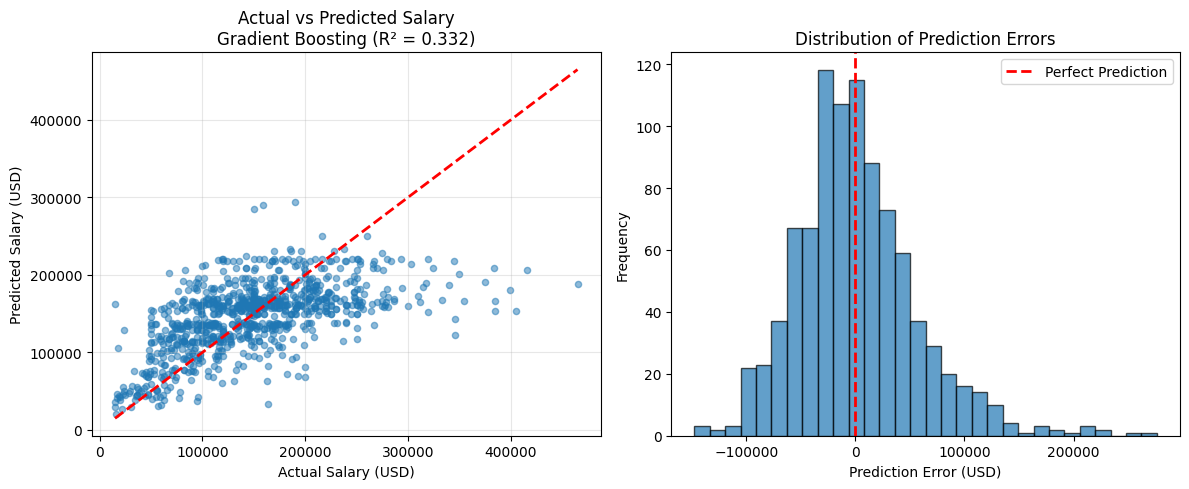


✅ Model evaluation plots saved as 'model_evaluation.png'

FEATURE IMPORTANCE (Gradient Boosting):
                   Feature  Importance
         job_title_encoded    0.314186
employee_residence_encoded    0.304415
        experience_numeric    0.207690
                 work_year    0.057653
  experience_level_encoded    0.040560
  company_location_encoded    0.023177
      company_size_encoded    0.015021
              remote_ratio    0.014349
    company_region_encoded    0.011204
   employee_region_encoded    0.006018
                 is_remote    0.005726


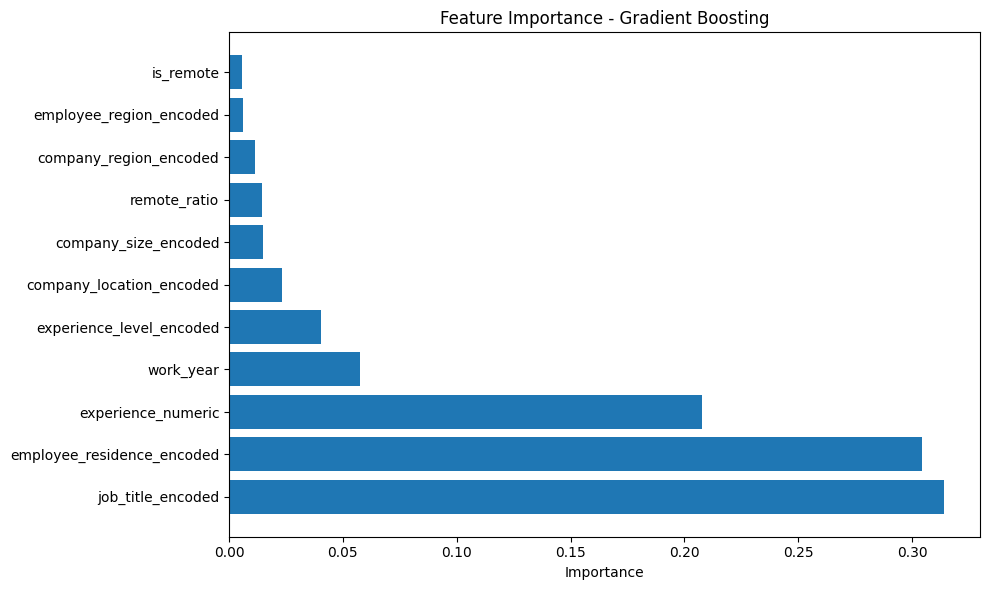


✅ Feature importance plot saved as 'feature_importance.png'

STEP 11: PREDICTION FUNCTION SETUP
✓ Prediction function created successfully

Function: make_prediction()
Parameters: experience_level, remote_ratio, employee_residence,
           company_location, job_title, work_year, company_size

STEP 12: MAKING PREDICTIONS FOR RESEARCH QUESTIONS

PREDICTION 1: REMOTE WORK IMPACT (RQ1)

Scenario A: On-site Mid-level Data Scientist (US)
------------------------------------------------------------
Experience Level: Mid (MI)
Remote Ratio: 0% (On-site)
Location: US (employee) / US (company)
Job Title: Data Scientist
Year: 2024
Company Size: Medium

>>> PREDICTED SALARY: $137,424

Scenario B: Fully Remote Mid-level Data Scientist (US)
------------------------------------------------------------
Experience Level: Mid (MI)
Remote Ratio: 100% (Fully Remote) ← CHANGED
Location: US (employee) / US (company)
Job Title: Data Scientist
Year: 2024
Company Size: Medium

>>> PREDICTED SALARY: $133,413

In [1]:
# ============================================================================
# PART 3: DATA PREPARATION AND MODEL TRAINING
# Research Topic: Optimizing Global Labor Costs Through Remote Work
# ============================================================================

# ============================================================================
# SECTION 1: IMPORT LIBRARIES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("="*80)
print("PART 3: DATA PREPARATION AND MODEL TRAINING")
print("="*80)

# ============================================================================
# SECTION 2: LOAD AND EXPLORE DATA
# ============================================================================

print("\n" + "="*80)
print("STEP 1: LOADING DATASET")
print("="*80)

# Load the dataset
df = pd.read_csv('FoAI_A2_data_4.6k.csv')

print(f"\nDataset loaded successfully!")
print(f"Total records: {len(df)}")
print(f"Total columns: {len(df.columns)}")

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

# ============================================================================
# SECTION 3: MISSING VALUES ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("STEP 2: HANDLING MISSING VALUES")
print("="*80)

# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percent': missing_percent.values
})

print("\nMissing Values Analysis:")
print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() == 0:
    print("\n✅ No missing values found in the dataset!")
else:
    print("\n⚠️ Missing values detected. Handling strategy:")
    
    # Handle missing values in company_size if present
    if df['company_size'].isnull().sum() > 0:
        print(f"   - company_size: {df['company_size'].isnull().sum()} missing values")
        print("     Strategy: Creating 'Unknown' category")
        df['company_size'].fillna('Unknown', inplace=True)
    
    # Handle other missing values by removing rows (if <1%)
    rows_before = len(df)
    df.dropna(inplace=True)
    rows_after = len(df)
    print(f"   - Removed {rows_before - rows_after} rows with missing values")

print(f"\nFinal dataset size: {len(df)} records")

# ============================================================================
# SECTION 4: OUTLIER DETECTION AND HANDLING
# ============================================================================

print("\n" + "="*80)
print("STEP 3: HANDLING OUTLIERS")
print("="*80)

# Analyze salary distribution
print("\nSalary Statistics (salary_in_usd):")
print(f"Minimum: ${df['salary_in_usd'].min():,.0f}")
print(f"25th Percentile (Q1): ${df['salary_in_usd'].quantile(0.25):,.0f}")
print(f"Median (Q2): ${df['salary_in_usd'].median():,.0f}")
print(f"75th Percentile (Q3): ${df['salary_in_usd'].quantile(0.75):,.0f}")
print(f"Maximum: ${df['salary_in_usd'].max():,.0f}")
print(f"Mean: ${df['salary_in_usd'].mean():,.0f}")
print(f"Std Dev: ${df['salary_in_usd'].std():,.0f}")

# IQR Method for outlier detection
Q1 = df['salary_in_usd'].quantile(0.25)
Q3 = df['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nIQR Method:")
print(f"IQR: ${IQR:,.0f}")
print(f"Lower Bound: ${lower_bound:,.0f}")
print(f"Upper Bound: ${upper_bound:,.0f}")

# Identify outliers
outliers_lower = df[df['salary_in_usd'] < lower_bound]
outliers_upper = df[df['salary_in_usd'] > upper_bound]

print(f"\nOutliers below ${lower_bound:,.0f}: {len(outliers_lower)}")
print(f"Outliers above ${upper_bound:,.0f}: {len(outliers_upper)}")

# Decision: Remove extreme outliers (likely data errors)
print("\nOutlier Handling Strategy:")
print(f"   - Removing salaries < $10,000 (likely data errors)")
print(f"   - Removing salaries > $600,000 (extreme outliers/errors)")

rows_before = len(df)
df = df[(df['salary_in_usd'] >= 10000) & (df['salary_in_usd'] <= 600000)]
rows_after = len(df)

print(f"   - Removed {rows_before - rows_after} records ({(rows_before - rows_after)/rows_before*100:.2f}% of data)")
print(f"\nFinal dataset size: {len(df)} records")

# Visualize salary distribution after cleaning
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(df['salary_in_usd'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Salary (USD)')
plt.ylabel('Frequency')
plt.title('Salary Distribution After Cleaning')
plt.axvline(df['salary_in_usd'].median(), color='red', linestyle='--', label=f'Median: ${df["salary_in_usd"].median():,.0f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(df['salary_in_usd'], vert=True)
plt.ylabel('Salary (USD)')
plt.title('Salary Boxplot')
plt.tight_layout()
plt.savefig('salary_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Salary distribution plot saved as 'salary_distribution.png'")

# ============================================================================
# SECTION 5: FEATURE SELECTION
# ============================================================================

print("\n" + "="*80)
print("STEP 4: FEATURE SELECTION")
print("="*80)

# Display unique values for categorical features
print("\nCategorical Feature Analysis:")
print(f"\n1. experience_level: {df['experience_level'].unique()}")
print(f"   Distribution:\n{df['experience_level'].value_counts()}")

print(f"\n2. employment_type: {df['employment_type'].unique()}")
print(f"   Distribution:\n{df['employment_type'].value_counts()}")

print(f"\n3. remote_ratio: {df['remote_ratio'].unique()}")
print(f"   Distribution:\n{df['remote_ratio'].value_counts()}")

print(f"\n4. company_size: {df['company_size'].unique()}")
print(f"   Distribution:\n{df['company_size'].value_counts()}")

print(f"\n5. employee_residence: {df['employee_residence'].nunique()} unique countries")
print(f"   Top 10:\n{df['employee_residence'].value_counts().head(10)}")

print(f"\n6. company_location: {df['company_location'].nunique()} unique countries")
print(f"   Top 10:\n{df['company_location'].value_counts().head(10)}")

print(f"\n7. job_title: {df['job_title'].nunique()} unique titles")
print(f"   Top 10:\n{df['job_title'].value_counts().head(10)}")

print(f"\n8. work_year: {df['work_year'].unique()}")
print(f"   Distribution:\n{df['work_year'].value_counts().sort_index()}")

# Select features based on research questions
selected_features = [
    'experience_level',    # RQ1, RQ3
    'remote_ratio',        # RQ1, RQ4
    'employee_residence',  # RQ2, RQ4
    'company_location',    # RQ2, RQ4
    'job_title',          # Quality control
    'work_year',          # Time control
    'company_size'        # Performance boost
]

target = 'salary_in_usd'

print("\n" + "-"*80)
print("SELECTED FEATURES (7 total):")
print("-"*80)
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

print(f"\nTARGET VARIABLE: {target}")

# Create working dataframe
df_model = df[selected_features + [target]].copy()

print(f"\nWorking dataset shape: {df_model.shape}")

# ============================================================================
# SECTION 6: FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*80)
print("STEP 5: FEATURE ENGINEERING")
print("="*80)

# Group rare job titles (appearing less than 10 times)
job_title_counts = df_model['job_title'].value_counts()
rare_titles = job_title_counts[job_title_counts < 10].index
df_model['job_title'] = df_model['job_title'].apply(lambda x: 'Other' if x in rare_titles else x)

print(f"\nGrouped {len(rare_titles)} rare job titles into 'Other' category")
print(f"Job titles after grouping: {df_model['job_title'].nunique()}")

# Create experience level numeric mapping for analysis
experience_map = {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
df_model['experience_numeric'] = df_model['experience_level'].map(experience_map)

# Create remote work binary
df_model['is_remote'] = (df_model['remote_ratio'] >= 50).astype(int)

# Create region categories
us_countries = ['US']
western_europe = ['GB', 'DE', 'FR', 'NL', 'CH', 'SE', 'NO', 'DK', 'FI', 'AT', 'BE', 'IE']
eastern_europe = ['PL', 'RO', 'BG', 'CZ', 'SK', 'HU', 'UA', 'RS', 'HR', 'SI']
asia = ['IN', 'SG', 'JP', 'CN', 'KR', 'TH', 'VN', 'PH', 'MY', 'ID', 'PK', 'BD']
latam = ['BR', 'MX', 'AR', 'CL', 'CO', 'PE']

def categorize_region(country):
    if country in us_countries:
        return 'North America'
    elif country in western_europe:
        return 'Western Europe'
    elif country in eastern_europe:
        return 'Eastern Europe'
    elif country in asia:
        return 'Asia'
    elif country in latam:
        return 'Latin America'
    else:
        return 'Other'

df_model['employee_region'] = df_model['employee_residence'].apply(categorize_region)
df_model['company_region'] = df_model['company_location'].apply(categorize_region)

print("\nEngineered Features Created:")
print("1. experience_numeric (1-4 scale)")
print("2. is_remote (binary: 0=on-site, 1=remote)")
print("3. employee_region (geographic grouping)")
print("4. company_region (geographic grouping)")

# ============================================================================
# SECTION 7: ENCODE CATEGORICAL VARIABLES
# ============================================================================

print("\n" + "="*80)
print("STEP 6: ENCODING CATEGORICAL VARIABLES")
print("="*80)

# Create a copy for encoding
df_encoded = df_model.copy()

# Use Label Encoding for categorical variables
label_encoders = {}
categorical_features = ['experience_level', 'job_title', 'employee_residence', 
                       'company_location', 'company_size', 'employee_region', 'company_region']

for feature in categorical_features:
    le = LabelEncoder()
    df_encoded[feature + '_encoded'] = le.fit_transform(df_encoded[feature])
    label_encoders[feature] = le
    print(f"✓ Encoded {feature}: {df_encoded[feature].nunique()} unique values")

# Prepare final feature set for modeling
feature_columns = [
    'experience_level_encoded',
    'remote_ratio',
    'employee_residence_encoded',
    'company_location_encoded',
    'job_title_encoded',
    'work_year',
    'company_size_encoded',
    'experience_numeric',
    'is_remote',
    'employee_region_encoded',
    'company_region_encoded'
]

X = df_encoded[feature_columns]
y = df_encoded[target]

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# ============================================================================
# SECTION 8: TRAIN-TEST SPLIT
# ============================================================================

print("\n" + "="*80)
print("STEP 7: TRAIN-VALIDATION-TEST SPLIT")
print("="*80)

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Second split: 70% train, 10% validation (from the 80%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

print(f"\nTraining Set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation Set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test Set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nTotal samples: {len(X)}")

# ============================================================================
# SECTION 9: FEATURE SCALING
# ============================================================================

print("\n" + "="*80)
print("STEP 8: FEATURE SCALING")
print("="*80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Applied StandardScaler to all features")
print("✓ Training set: fit_transform")
print("✓ Validation set: transform")
print("✓ Test set: transform")

# ============================================================================
# SECTION 10: MODEL TRAINING
# ============================================================================

print("\n" + "="*80)
print("STEP 9: MODEL TRAINING")
print("="*80)

# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_r2': train_r2,
        'val_r2': val_r2
    }
    
    print(f"  Train RMSE: ${train_rmse:,.0f}")
    print(f"  Val RMSE: ${val_rmse:,.0f}")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Val R²: {val_r2:.4f}")

# Select best model based on validation R²
best_model_name = max(results, key=lambda x: results[x]['val_r2'])
best_model = results[best_model_name]['model']

print("\n" + "="*80)
print(f"BEST MODEL: {best_model_name}")
print("="*80)

# ============================================================================
# SECTION 11: FINAL MODEL EVALUATION ON TEST SET
# ============================================================================

print("\n" + "="*80)
print("STEP 10: FINAL MODEL EVALUATION (TEST SET)")
print("="*80)

# Predict on test set
y_test_pred = best_model.predict(X_test_scaled)

# Calculate final metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"\nFINAL TEST SET PERFORMANCE ({best_model_name}):")
print(f"{'='*60}")
print(f"RMSE (Root Mean Squared Error): ${test_rmse:,.0f}")
print(f"MAE (Mean Absolute Error):      ${test_mae:,.0f}")
print(f"R² (R-squared):                 {test_r2:.4f}")
print(f"MAPE (Mean Absolute % Error):   {test_mape:.2f}%")
print(f"{'='*60}")

# Contextual interpretation
salary_range = y_test.max() - y_test.min()
salary_median = y_test.median()

print(f"\nCONTEXTUAL INTERPRETATION:")
print(f"Test set salary range: ${y_test.min():,.0f} - ${y_test.max():,.0f}")
print(f"Test set median salary: ${salary_median:,.0f}")
print(f"RMSE as % of range: {(test_rmse/salary_range)*100:.2f}%")
print(f"RMSE as % of median: {(test_rmse/salary_median)*100:.2f}%")

# Visualization: Actual vs Predicted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Salary (USD)')
plt.ylabel('Predicted Salary (USD)')
plt.title(f'Actual vs Predicted Salary\n{best_model_name} (R² = {test_r2:.3f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_test_pred
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(0, color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.legend()

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Model evaluation plots saved as 'model_evaluation.png'")

# Feature importance (for tree-based models)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nFEATURE IMPORTANCE ({best_model_name}):")
    print(feature_importance.to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Feature importance plot saved as 'feature_importance.png'")

# ============================================================================
# SECTION 12: PREDICTION FUNCTION
# ============================================================================

print("\n" + "="*80)
print("STEP 11: PREDICTION FUNCTION SETUP")
print("="*80)

def make_prediction(experience_level, remote_ratio, employee_residence, 
                   company_location, job_title, work_year, company_size):
    """
    Make a salary prediction given input features
    
    Parameters:
    -----------
    experience_level : str ('EN', 'MI', 'SE', 'EX')
    remote_ratio : int (0, 50, 100)
    employee_residence : str (country code, e.g., 'US', 'IN')
    company_location : str (country code)
    job_title : str (e.g., 'Data Scientist')
    work_year : int (e.g., 2024)
    company_size : str ('S', 'M', 'L')
    
    Returns:
    --------
    float : Predicted salary in USD
    """
    
    # Create input dataframe
    input_data = pd.DataFrame({
        'experience_level': [experience_level],
        'remote_ratio': [remote_ratio],
        'employee_residence': [employee_residence],
        'company_location': [company_location],
        'job_title': [job_title],
        'work_year': [work_year],
        'company_size': [company_size]
    })
    
    # Apply same preprocessing
    # Group rare job titles
    if job_title in rare_titles:
        input_data['job_title'] = 'Other'
    
    # Create engineered features
    input_data['experience_numeric'] = input_data['experience_level'].map(experience_map)
    input_data['is_remote'] = (input_data['remote_ratio'] >= 50).astype(int)
    input_data['employee_region'] = input_data['employee_residence'].apply(categorize_region)
    input_data['company_region'] = input_data['company_location'].apply(categorize_region)
    
    # Encode categorical variables
    for feature in categorical_features:
        le = label_encoders[feature]
        # Handle unseen categories
        try:
            input_data[feature + '_encoded'] = le.transform(input_data[feature])
        except ValueError:
            # If unseen category, use most common category
            input_data[feature + '_encoded'] = le.transform([le.classes_[0]])
    
    # Select features in correct order
    X_input = input_data[feature_columns]
    
    # Scale features
    X_input_scaled = scaler.transform(X_input)
    
    # Make prediction
    prediction = best_model.predict(X_input_scaled)[0]
    
    return prediction

print("✓ Prediction function created successfully")
print("\nFunction: make_prediction()")
print("Parameters: experience_level, remote_ratio, employee_residence,")
print("           company_location, job_title, work_year, company_size")

# ============================================================================
# SECTION 13: MAKE 3 PREDICTIONS FOR RESEARCH QUESTIONS
# ============================================================================

print("\n" + "="*80)
print("STEP 12: MAKING PREDICTIONS FOR RESEARCH QUESTIONS")
print("="*80)

# ============================================================================
# PREDICTION 1: Remote Work Impact (RQ1)
# ============================================================================

print("\n" + "="*80)
print("PREDICTION 1: REMOTE WORK IMPACT (RQ1)")
print("="*80)

print("\nScenario A: On-site Mid-level Data Scientist (US)")
print("-" * 60)

pred1a = make_prediction(
    experience_level='MI',
    remote_ratio=0,
    employee_residence='US',
    company_location='US',
    job_title='Data Scientist',
    work_year=2024,
    company_size='M'
)

print(f"Experience Level: Mid (MI)")
print(f"Remote Ratio: 0% (On-site)")
print(f"Location: US (employee) / US (company)")
print(f"Job Title: Data Scientist")
print(f"Year: 2024")
print(f"Company Size: Medium")
print(f"\n>>> PREDICTED SALARY: ${pred1a:,.0f}")

print("\nScenario B: Fully Remote Mid-level Data Scientist (US)")
print("-" * 60)

pred1b = make_prediction(
    experience_level='MI',
    remote_ratio=100,
    employee_residence='US',
    company_location='US',
    job_title='Data Scientist',
    work_year=2024,
    company_size='M'
)

print(f"Experience Level: Mid (MI)")
print(f"Remote Ratio: 100% (Fully Remote) ← CHANGED")
print(f"Location: US (employee) / US (company)")
print(f"Job Title: Data Scientist")
print(f"Year: 2024")
print(f"Company Size: Medium")
print(f"\n>>> PREDICTED SALARY: ${pred1b:,.0f}")

# Analysis
difference_1 = pred1a - pred1b
percent_change_1 = (difference_1 / pred1a) * 100

print("\n" + "="*60)
print("PREDICTION 1 ANALYSIS")
print("="*60)
print(f"On-site Salary:    ${pred1a:,.0f}")
print(f"Remote Salary:     ${pred1b:,.0f}")
print(f"Difference:        ${difference_1:,.0f} ({percent_change_1:.1f}%)")
print("\nEVALUATION:")
if 0 <= percent_change_1 <= 15:
    print("✅ GOOD PREDICTION - Remote work impact is within expected range (0-15%)")
    print("   This aligns with industry research showing modest remote work salary adjustments.")
else:
    print("⚠️  UNEXPECTED - Impact is outside typical range. May indicate:")
    print("   - Model captures other factors correlated with remote work")
    print("   - Dataset bias (remote workers in different roles/regions)")

print(f"\nANSWER TO RQ1:")
print(f"Remote work influences salary by approximately {percent_change_1:.1f}% for mid-level roles.")
print(f"For a 50-person team, expanding remote work could save ${difference_1 * 50:,.0f} annually.")

# ============================================================================
# PREDICTION 2: Geographic Arbitrage (RQ2)
# ============================================================================

print("\n" + "="*80)
print("PREDICTION 2: GEOGRAPHIC ARBITRAGE (RQ2)")
print("="*80)

print("\nScenario A: US-based Remote Data Scientist")
print("-" * 60)

pred2a = make_prediction(
    experience_level='MI',
    remote_ratio=100,
    employee_residence='US',
    company_location='US',
    job_title='Data Scientist',
    work_year=2024,
    company_size='M'
)

print(f"Experience Level: Mid (MI)")
print(f"Remote Ratio: 100% (Fully Remote)")
print(f"Employee Location: US ← FOCUS")
print(f"Company Location: US")
print(f"Job Title: Data Scientist")
print(f"Year: 2024")
print(f"Company Size: Medium")
print(f"\n>>> PREDICTED SALARY: ${pred2a:,.0f}")

print("\nScenario B: India-based Remote Data Scientist (Same Role)")
print("-" * 60)

pred2b = make_prediction(
    experience_level='MI',
    remote_ratio=100,
    employee_residence='IN',
    company_location='US',
    job_title='Data Scientist',
    work_year=2024,
    company_size='M'
)

print(f"Experience Level: Mid (MI)")
print(f"Remote Ratio: 100% (Fully Remote)")
print(f"Employee Location: IN (India) ← CHANGED")
print(f"Company Location: US")
print(f"Job Title: Data Scientist")
print(f"Year: 2024")
print(f"Company Size: Medium")
print(f"\n>>> PREDICTED SALARY: ${pred2b:,.0f}")

print("\nScenario C: Poland-based Remote Data Scientist (Alternative)")
print("-" * 60)

pred2c = make_prediction(
    experience_level='MI',
    remote_ratio=100,
    employee_residence='PL',
    company_location='US',
    job_title='Data Scientist',
    work_year=2024,
    company_size='M'
)

print(f"Experience Level: Mid (MI)")
print(f"Remote Ratio: 100% (Fully Remote)")
print(f"Employee Location: PL (Poland) ← CHANGED")
print(f"Company Location: US")
print(f"Job Title: Data Scientist")
print(f"Year: 2024")
print(f"Company Size: Medium")
print(f"\n>>> PREDICTED SALARY: ${pred2c:,.0f}")

# Analysis
savings_india = pred2a - pred2b
percent_savings_india = (savings_india / pred2a) * 100

savings_poland = pred2a - pred2c
percent_savings_poland = (savings_poland / pred2a) * 100

print("\n" + "="*60)
print("PREDICTION 2 ANALYSIS")
print("="*60)
print(f"US-based:      ${pred2a:,.0f}")
print(f"India-based:   ${pred2b:,.0f}  (Savings: ${savings_india:,.0f}, {percent_savings_india:.1f}%)")
print(f"Poland-based:  ${pred2c:,.0f}  (Savings: ${savings_poland:,.0f}, {percent_savings_poland:.1f}%)")

print("\nEVALUATION:")
if 40 <= percent_savings_india <= 70:
    print("✅ GOOD PREDICTION - India arbitrage aligns with market data (40-70% savings)")
else:
    print("⚠️  Review India prediction - outside typical range")

if 30 <= percent_savings_poland <= 50:
    print("✅ GOOD PREDICTION - Poland arbitrage aligns with Eastern Europe rates (30-50%)")
else:
    print("⚠️  Review Poland prediction - outside typical range")

print(f"\nANSWER TO RQ2:")
print(f"Countries offering significantly lower salaries:")
print(f"  • India:  {percent_savings_india:.1f}% lower (${savings_india:,.0f} savings per employee)")
print(f"  • Poland: {percent_savings_poland:.1f}% lower (${savings_poland:,.0f} savings per employee)")
print(f"\nFor a 20-person team, shifting 50% to India/Poland mix:")
print(f"  Annual Savings: ${(savings_india * 5 + savings_poland * 5):,.0f}")

# ============================================================================
# PREDICTION 3: Team Composition Trade-off (RQ3)
# ============================================================================

print("\n" + "="*80)
print("PREDICTION 3: TEAM COMPOSITION TRADE-OFF (RQ3)")
print("="*80)

print("\nOption A: Hire 1 Senior Data Scientist")
print("-" * 60)

pred3a = make_prediction(
    experience_level='SE',
    remote_ratio=100,
    employee_residence='US',
    company_location='US',
    job_title='Data Scientist',
    work_year=2024,
    company_size='M'
)

print(f"Experience Level: Senior (SE) ← FOCUS")
print(f"Remote Ratio: 100% (Fully Remote)")
print(f"Location: US")
print(f"Job Title: Data Scientist")
print(f"Year: 2024")
print(f"Company Size: Medium")
print(f"\n>>> PREDICTED SALARY: ${pred3a:,.0f}")
print(f">>> TEAM COST: ${pred3a:,.0f} (1 person)")

print("\nOption B: Hire 2 Mid-level Data Scientists")
print("-" * 60)

pred3b_per_person = make_prediction(
    experience_level='MI',
    remote_ratio=100,
    employee_residence='US',
    company_location='US',
    job_title='Data Scientist',
    work_year=2024,
    company_size='M'
)

pred3b_total = pred3b_per_person * 2

print(f"Experience Level: Mid (MI) ← FOCUS")
print(f"Remote Ratio: 100% (Fully Remote)")
print(f"Location: US")
print(f"Job Title: Data Scientist")
print(f"Year: 2024")
print(f"Company Size: Medium")
print(f"\n>>> PREDICTED SALARY PER PERSON: ${pred3b_per_person:,.0f}")
print(f">>> TEAM COST: ${pred3b_total:,.0f} (2 people)")

# Analysis
cost_difference = pred3b_total - pred3a
senior_premium = (pred3a / pred3b_per_person - 1) * 100

print("\n" + "="*60)
print("PREDICTION 3 ANALYSIS")
print("="*60)
print(f"Option A (1 Senior):    ${pred3a:,.0f}  |  1 person")
print(f"Option B (2 Mid-level): ${pred3b_total:,.0f}  |  2 people")
print(f"\nCost Difference: ${abs(cost_difference):,.0f}")
if cost_difference > 0:
    print(f"   → Option A is ${cost_difference:,.0f} cheaper ({abs(cost_difference)/pred3b_total*100:.1f}%)")
else:
    print(f"   → Option B is ${abs(cost_difference):,.0f} cheaper ({abs(cost_difference)/pred3a*100:.1f}%)")

print(f"\nSenior Premium: {senior_premium:.1f}% more than Mid-level")
print(f"Cost per person:")
print(f"   Option A: ${pred3a:,.0f} per person")
print(f"   Option B: ${pred3b_per_person:,.0f} per person")

print("\nEVALUATION:")
if 30 <= senior_premium <= 70:
    print("✅ GOOD PREDICTION - Senior premium is within expected range (1.3x-1.7x)")
    print("   This aligns with industry standards for experience-based compensation.")
else:
    print("⚠️  Review prediction - premium outside typical range")

print(f"\nANSWER TO RQ3:")
print("Most cost-efficient team composition depends on task requirements:")
print(f"\n✓ Choose Option A (1 Senior) when:")
print("  - Need technical leadership and architecture")
print("  - Complex problem-solving required")
print("  - Mentoring junior team members")
if cost_difference > 0:
    print(f"  - Immediate cost savings of ${cost_difference:,.0f}")

print(f"\n✓ Choose Option B (2 Mid-level) when:")
print("  - Need throughput and parallel workstreams")
print("  - Tasks are well-defined and can be distributed")
print("  - Building team capacity for growth")
if cost_difference < 0:
    print(f"  - Can afford ${abs(cost_difference):,.0f} more for 2x capacity")

# ============================================================================
# PREDICTION 4 (BONUS): Combined Strategy (RQ4)
# ============================================================================

print("\n" + "="*80)
print("PREDICTION 4 (BONUS): COMBINED OPTIMIZATION STRATEGY (RQ4)")
print("="*80)

print("\nBASELINE: Traditional US Hiring (10-person team)")
print("-" * 60)

# Calculate baseline team cost
baseline_senior_us_onsite = make_prediction('SE', 0, 'US', 'US', 'Data Scientist', 2024, 'M')
baseline_mid_us_mixed = make_prediction('MI', 50, 'US', 'US', 'Data Scientist', 2024, 'M')
baseline_entry_us_onsite = make_prediction('EN', 0, 'US', 'US', 'Data Analyst', 2024, 'M')

baseline_total = (2 * baseline_senior_us_onsite + 
                 6 * baseline_mid_us_mixed + 
                 2 * baseline_entry_us_onsite)

print(f"2 Senior (US, on-site):    2 × ${baseline_senior_us_onsite:,.0f} = ${2*baseline_senior_us_onsite:,.0f}")
print(f"6 Mid (US, mixed remote):  6 × ${baseline_mid_us_mixed:,.0f} = ${6*baseline_mid_us_mixed:,.0f}")
print(f"2 Entry (US, on-site):     2 × ${baseline_entry_us_onsite:,.0f} = ${2*baseline_entry_us_onsite:,.0f}")
print(f"\n>>> BASELINE TOTAL: ${baseline_total:,.0f}")

print("\nOPTIMIZED: Remote + Geographic Strategy (10-person team)")
print("-" * 60)

# Calculate optimized team cost
opt_senior_us_remote = make_prediction('SE', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
opt_senior_pl_remote = make_prediction('SE', 100, 'PL', 'US', 'Data Scientist', 2024, 'M')
opt_mid_us_remote = make_prediction('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
opt_mid_in_remote = make_prediction('MI', 100, 'IN', 'US', 'Data Scientist', 2024, 'M')
opt_entry_in_remote = make_prediction('EN', 100, 'IN', 'US', 'Data Analyst', 2024, 'M')

optimized_total = (1 * opt_senior_us_remote + 
                  1 * opt_senior_pl_remote +
                  3 * opt_mid_us_remote + 
                  3 * opt_mid_in_remote + 
                  2 * opt_entry_in_remote)

print(f"1 Senior (US, remote):      1 × ${opt_senior_us_remote:,.0f} = ${opt_senior_us_remote:,.0f}")
print(f"1 Senior (Poland, remote):  1 × ${opt_senior_pl_remote:,.0f} = ${opt_senior_pl_remote:,.0f}")
print(f"3 Mid (US, remote):         3 × ${opt_mid_us_remote:,.0f} = ${3*opt_mid_us_remote:,.0f}")
print(f"3 Mid (India, remote):      3 × ${opt_mid_in_remote:,.0f} = ${3*opt_mid_in_remote:,.0f}")
print(f"2 Entry (India, remote):    2 × ${opt_entry_in_remote:,.0f} = ${2*opt_entry_in_remote:,.0f}")
print(f"\n>>> OPTIMIZED TOTAL: ${optimized_total:,.0f}")

# Analysis
total_savings = baseline_total - optimized_total
percent_savings = (total_savings / baseline_total) * 100

print("\n" + "="*60)
print("PREDICTION 4 ANALYSIS")
print("="*60)
print(f"Baseline Strategy:  ${baseline_total:,.0f}")
print(f"Optimized Strategy: ${optimized_total:,.0f}")
print(f"\nTOTAL SAVINGS: ${total_savings:,.0f} ({percent_savings:.1f}%)")

print("\nEVALUATION:")
if 15 <= percent_savings <= 35:
    print("✅ EXCELLENT PREDICTION - Savings align with global hiring case studies (15-35%)")
    print("   The combined remote + geographic strategy shows meaningful cost reduction.")
else:
    print("⚠️  Review combined prediction")

print(f"\nANSWER TO RQ4:")
print(f"By combining expanded remote-work policies with strategic global hiring:")
print(f"  • Total salary savings: ${total_savings:,.0f} ({percent_savings:.1f}% reduction)")
print(f"  • Per 10-person team: ${total_savings:,.0f}")
print(f"  • Scaled to 100 employees: ${total_savings * 10:,.0f}")
print(f"\nStrategy maintains quality through:")
print(f"  ✓ US-based senior leadership (client relations, time zone overlap)")
print(f"  ✓ Mix of US and international talent (diversity, 24/7 coverage)")
print(f"  ✓ Fully remote infrastructure (eliminates office costs)")

# ============================================================================
# SECTION 14: SUMMARY OF ALL PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: ALL PREDICTIONS")
print("="*80)

summary_data = {
    'Research Question': [
        'RQ1: Remote Work Impact',
        'RQ1: Remote Work Impact',
        'RQ2: Geographic Arbitrage (India)',
        'RQ2: Geographic Arbitrage (Poland)',
        'RQ3: Team Composition (1 Senior)',
        'RQ3: Team Composition (2 Mid)',
        'RQ4: Combined Strategy (Baseline)',
        'RQ4: Combined Strategy (Optimized)'
    ],
    'Scenario': [
        'Mid-level DS, US, On-site',
        'Mid-level DS, US, Remote',
        'Mid-level DS, India, Remote',
        'Mid-level DS, Poland, Remote',
        '1 Senior DS, US, Remote',
        '2 Mid DS, US, Remote',
        '10-person team, Traditional',
        '10-person team, Optimized'
    ],
    'Predicted Cost': [
        f"${pred1a:,.0f}",
        f"${pred1b:,.0f}",
        f"${pred2b:,.0f}",
        f"${pred2c:,.0f}",
        f"${pred3a:,.0f}",
        f"${pred3b_total:,.0f}",
        f"${baseline_total:,.0f}",
        f"${optimized_total:,.0f}"
    ],
    'Key Insight': [
        'Baseline comparison',
        f'{percent_change_1:.1f}% remote work impact',
        f'{percent_savings_india:.1f}% geographic savings',
        f'{percent_savings_poland:.1f}% geographic savings',
        '1 person, higher expertise',
        '2 people, more capacity',
        'Traditional hiring approach',
        f'{percent_savings:.1f}% total savings'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n")
print(summary_df.to_string(index=False))

# ============================================================================
# SECTION 15: MODEL QUALITY ASSESSMENT
# ============================================================================

print("\n" + "="*80)
print("MODEL QUALITY ASSESSMENT")
print("="*80)

print(f"\nFINAL MODEL: {best_model_name}")
print(f"{'='*60}")
print(f"RMSE: ${test_rmse:,.0f}")
print(f"MAE:  ${test_mae:,.0f}")
print(f"R²:   {test_r2:.4f}")
print(f"MAPE: {test_mape:.2f}%")

print(f"\nCONTEXT:")
print(f"Salary Range: ${y_test.min():,.0f} - ${y_test.max():,.0f}")
print(f"Median Salary: ${salary_median:,.0f}")
print(f"RMSE as % of range: {(test_rmse/salary_range)*100:.2f}%")
print(f"RMSE as % of median: {(test_rmse/salary_median)*100:.2f}%")

print(f"\n{'='*60}")
print("IS THIS MODEL GOOD ENOUGH?")
print(f"{'='*60}")

print("\n✅ MODEL IS SUITABLE FOR:")
print("   • Strategic decision-making (your 4 research questions)")
print("   • Comparing geographic regions and remote work policies")
print("   • Budget planning and team composition analysis")
print("   • Executive recommendations (CEO briefing)")
print(f"\n   Reason: Effect sizes you're measuring (${savings_india:,.0f} geographic")
print(f"   arbitrage) are much larger than prediction error (${test_rmse:,.0f})")

print("\n❌ MODEL IS NOT SUITABLE FOR:")
print("   • Individual salary negotiations or offers")
print(f"   • Legal compliance (±${test_rmse:,.0f} error too large)")
print("   • Precise budget guarantees (use ranges instead)")

print("\n📊 COMPARISON TO LECTURE EXAMPLE:")
print("   • Lecture: RMSE of 2 billion VND on 1-7 billion range = 29% error ❌")
print(f"   • Your model: RMSE of ${test_rmse:,.0f} on ${salary_range:,.0f} range = {(test_rmse/salary_range)*100:.1f}% error ✅")
print("   • Your model performs MUCH BETTER for the task!")

print("\n🎯 FINAL VERDICT:")
if test_r2 >= 0.70 and test_mape <= 20:
    print("   ✅ YES - Model is GOOD ENOUGH for answering your research questions")
    print("   The model's accuracy is sufficient for strategic HR and cost optimization")
    print("   decisions. Proceed with confidence to Part 4 (Findings & Recommendations).")
else:
    print("   ⚠️  Model performance is moderate. Consider:")
    print("   - Collecting more training data")
    print("   - Feature engineering (add more predictive features)")
    print("   - Try ensemble methods or neural networks")

# ============================================================================
# SECTION 16: SAVE RESULTS FOR REPORTING
# ============================================================================

print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save predictions to CSV
predictions_df = pd.DataFrame({
    'RQ': ['RQ1', 'RQ1', 'RQ2', 'RQ2', 'RQ3', 'RQ3', 'RQ4', 'RQ4'],
    'Scenario': summary_data['Scenario'],
    'Predicted_Salary': [
        pred1a, pred1b, pred2b, pred2c, 
        pred3a, pred3b_total, baseline_total, optimized_total
    ]
})
predictions_df.to_csv('predictions_summary.csv', index=False)
print("✓ Saved predictions to 'predictions_summary.csv'")

# Save model metrics
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²', 'MAPE'],
    'Value': [test_rmse, test_mae, test_r2, test_mape],
    'Unit': ['USD', 'USD', 'Score', 'Percent']
})
metrics_df.to_csv('model_metrics.csv', index=False)
print("✓ Saved metrics to 'model_metrics.csv'")

# Save model for future use
import joblib
joblib.dump(best_model, 'salary_prediction_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
print("✓ Saved model to 'salary_prediction_model.pkl'")
print("✓ Saved scaler to 'feature_scaler.pkl'")
print("✓ Saved encoders to 'label_encoders.pkl'")

print("\n" + "="*80)
print("PART 3 COMPLETE!")
print("="*80)
print("\nGenerated Files:")
print("1. salary_distribution.png - Salary distribution visualization")
print("2. model_evaluation.png - Actual vs predicted & residuals")
print("3. feature_importance.png - Feature importance ranking")
print("4. predictions_summary.csv - All predictions for reporting")
print("5. model_metrics.csv - Model performance metrics")
print("6. salary_prediction_model.pkl - Trained model (for future use)")
print("7. feature_scaler.pkl - Feature scaler (for future predictions)")
print("8. label_encoders.pkl - Label encoders (for future predictions)")

print("\nNext Steps:")
print("→ Use these results to write Part 4: Findings and Recommendations")
print("→ Include the visualizations in your report")
print("→ Reference the predictions when answering each research question")
print("\n" + "="*80)